In [1]:
import gpxpy
import pandas as pd
import numpy as np
import geopy.distance

def convert_gpx(path):
    with open(path, 'r') as f:
        gpx = gpxpy.parse(f)
        data = gpx.tracks[0].segments[0].points



    df = pd.DataFrame(columns=['lat', 'lon', 'ele', 'time', 'power', 'hr', 'cad', 'temperature'
                           # don't add empty columns                           ,'distance','alt_difference', 'duration'
                           ])
    for point in data:
        power = None
        hr = None
        cadence = None
        temp = None
        # Safely access extensions
        for ext in point.extensions:
            if ext.tag.endswith('power'):
                power = int(ext.text)
            if ext is not None:
                for child in ext:
                    if (child.tag.endswith('hr')):
                        hr = int(child.text)
                    if (child.tag.endswith('cad')):
                        cadence = int(child.text)
                    if (child.tag.endswith('atemp')):
                        temp = float(child.text)
        new_row = pd.DataFrame({'lat': [point.latitude],
                                'lon': [point.longitude],
                                'ele': [point.elevation],
                                'time': [point.time],
                                'power': [power]
                                   , 'hr': [hr],
                                'cad': [cadence]
                                   , 'temperature': [temp]
                                })
        df = pd.concat([df, new_row], ignore_index=True)

    df['hr'] = df['hr'].astype(int)
    df['cad'] = df['cad'].astype(int)
    df['power'] = df['power'].astype(float)
    df['temperature'] = df['temperature'].astype(float)
    df['distance'] = pd.Series(dtype='float')
    df['alt_difference'] = pd.Series(dtype='float')
    df['duration'] = pd.Series(dtype='float')
    df['velocity'] = pd.Series(dtype='float')

    for i in range(1, len(df)):
        coords_1 = (df.loc[i-1, 'lat'],df.loc[i-1, 'lon'])
        coords_2 = (df.loc[i, 'lat'],df.loc[i, 'lon'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        elevation =  df.loc[i, 'ele'] - df.loc[i-1, 'ele']
        duration = (df.loc[i, 'time'] - df.loc[i-1, 'time']).total_seconds()
        # filter out odd gps coords
        if distance > 30 or distance == 0:
            distance = None
            elevation = None
            duration = None
        if distance is not None and elevation is not None:
            velocity = 3.6 * np.sqrt(distance**2 + elevation**2)
        else:
            velocity = None
        df.loc[i, 'distance'] = distance
        df.loc[i, 'alt_difference'] = elevation
        df.loc[i, 'velocity'] = velocity
        df.loc[i, 'duration'] = duration

    df['gradient'] = df['alt_difference'].mul(100).div(df['distance'].replace(0, np.nan))
    df['time'] = df['time'].dt.tz_localize(None)
    df = df.set_index('time')
    return df

paths = ['Strava/Ronde_Van_Vlaanderen_2022.gpx','Strava/L_Etape_2022.gpx', 'Strava/L_Etape_2023.gpx', 'Strava/L_Etape_2024.gpx']

dfs = []

for path in paths:
    df = convert_gpx(path)
    dfs.append(df)

def convert_df(df):
    strava = df[['power'
        ,'hr'
        ,'cad'
        ,'temperature'
        ,'distance'
        ,'gradient'
        ,'velocity'
                 ]].dropna()


    strava = strava.drop(strava[strava.cad < 30].index)
    return strava

stravas = []

for df in dfs:
    strava = convert_df(df)
    stravas.append(strava)

C:\Users\lilyh\AppData\Local\Temp\ipykernel_10728\2341962915.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)
C:\Users\lilyh\AppData\Local\Temp\ipykernel_10728\2341962915.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)
C:\Users\lilyh\AppData\Local\Temp\ipykernel_10728\2341962915.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a fu

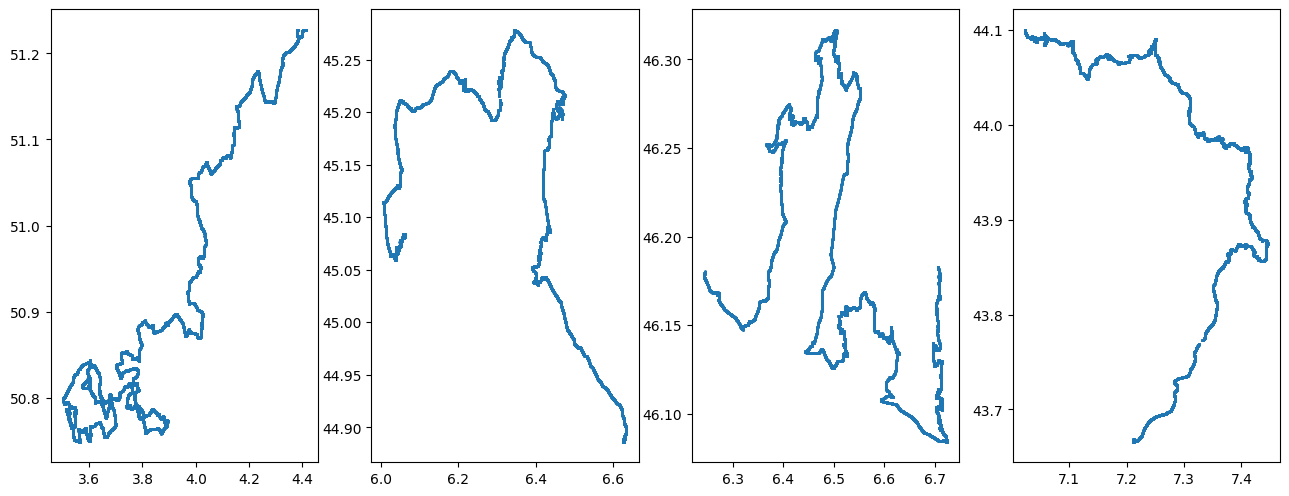

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(dfs)):
    df = dfs[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.plot(df.lon, df.lat, 'o', markersize=1)

## Heartrate and Cadence

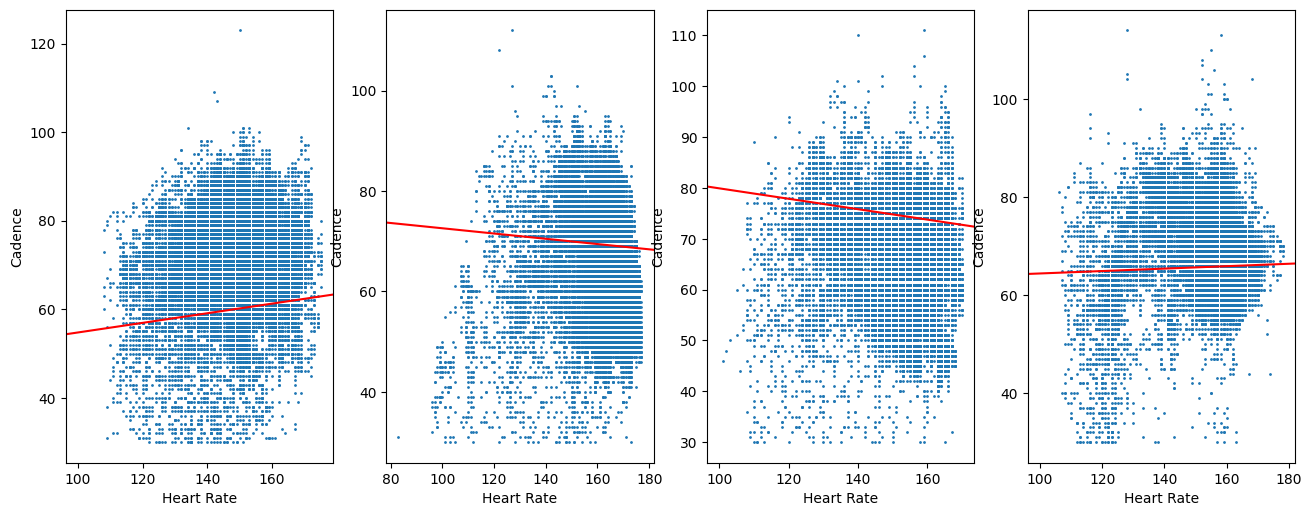

In [3]:
fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(stravas)):
    strava = stravas[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.scatter(strava.hr, strava.cad, s =1)
    plt.xlabel("Heart Rate")
    plt.ylabel("Cadence")
    m, b = np.polyfit(strava.hr, strava.cad, deg=1)
    plt.axline(xy1=(100, b), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

## Cadence and Power

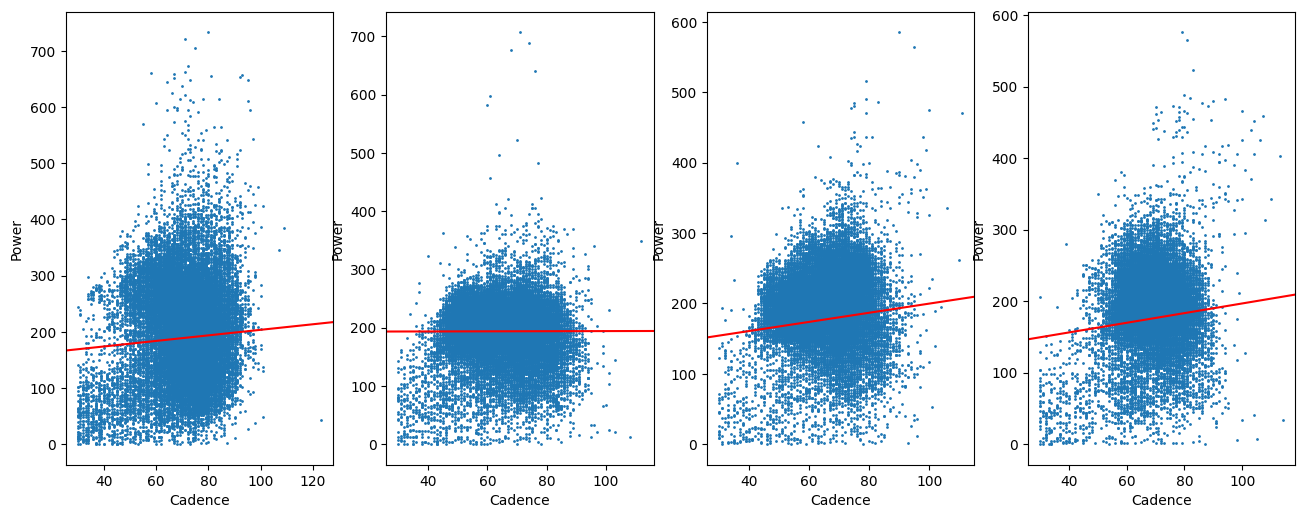

In [4]:
fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(stravas)):
    strava = stravas[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.scatter(strava.cad, strava.power,  s =1)
    plt.xlabel("Cadence")
    plt.ylabel("Power")
    m, b = np.polyfit(strava.cad, strava.power, deg=1)
    plt.axline(xy1=(30, b), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

## Heartrate and Power

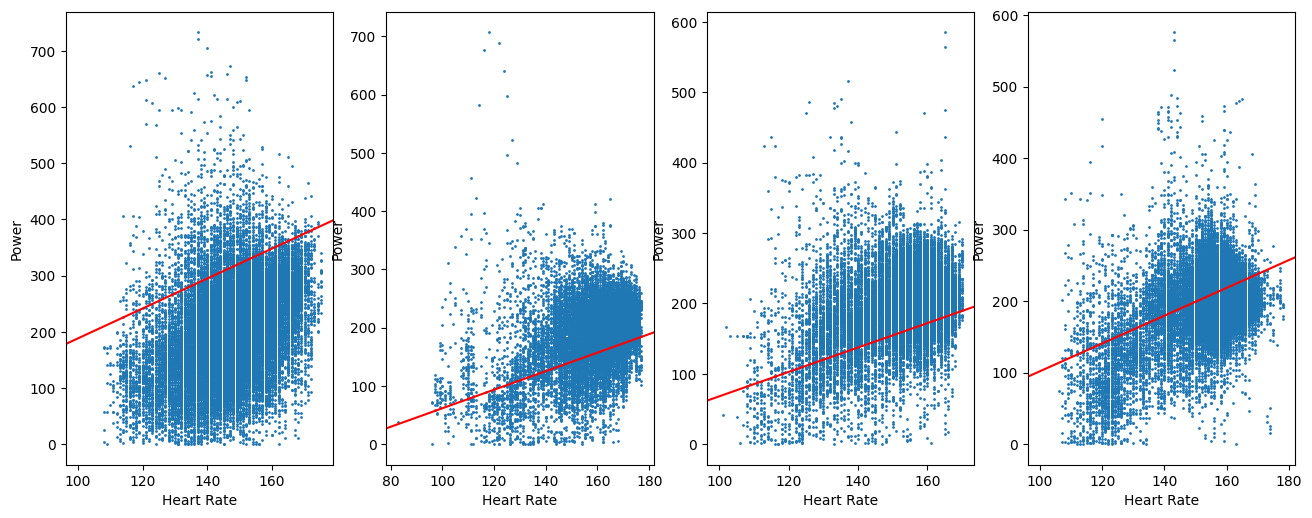

In [5]:
fig = plt.figure(figsize=(5*len(dfs), 5*len(dfs)))
for i in range(len(stravas)):
    strava = stravas[i]
    ax = fig.add_subplot(3,len(dfs)+1, i+1)
    ax.scatter(strava.hr, strava.power, s =1)
    plt.xlabel("Heart Rate")
    plt.ylabel("Power")
    m, b = np.polyfit(strava.hr, strava.power, deg=1)

    plt.axline(xy1=(100, b * -1), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

Mean squared error: 6867.23
Coefficient of determination: 0.00


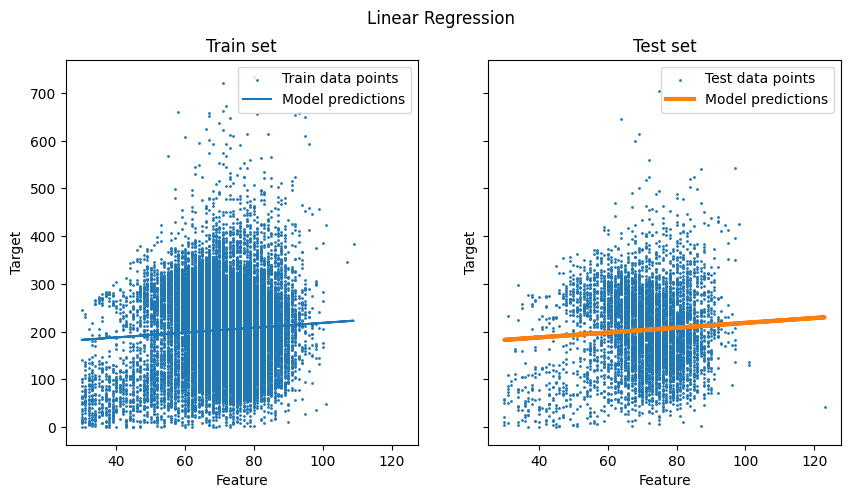

Mean squared error: 2217.73
Coefficient of determination: -0.00


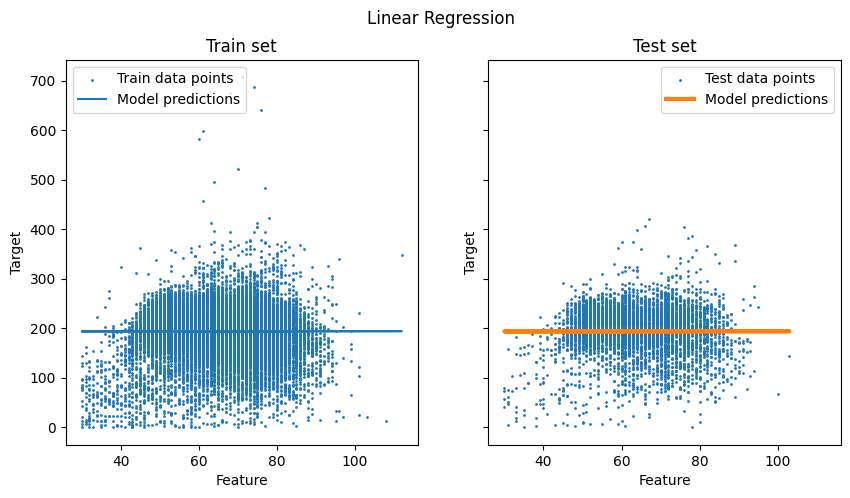

Mean squared error: 2419.03
Coefficient of determination: 0.02


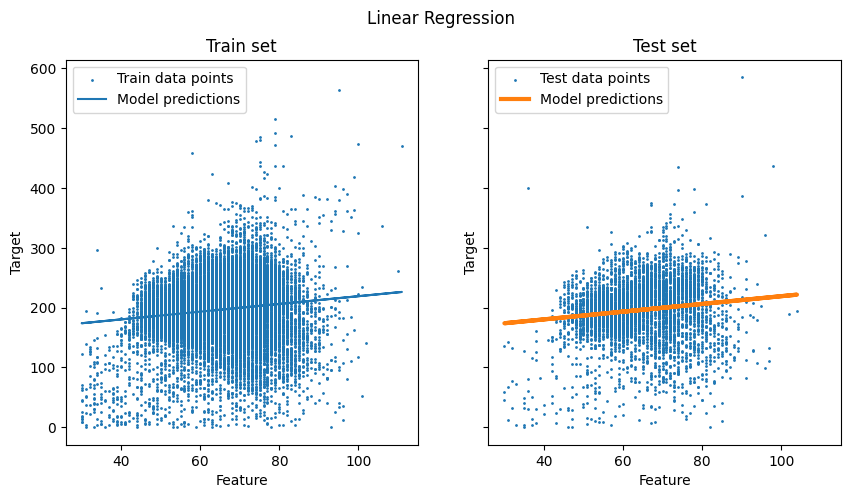

Mean squared error: 2259.78
Coefficient of determination: 0.01


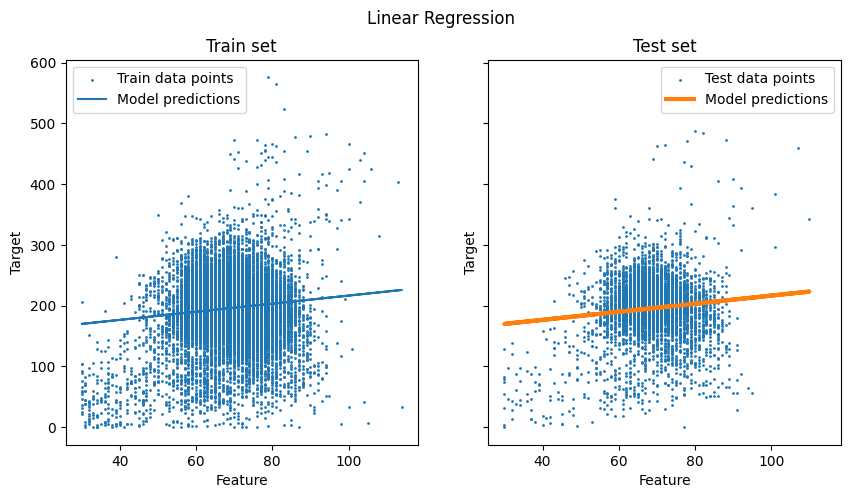

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.preprocessing import scale

for i in range(len(stravas)):
    strava = stravas[i]
    stravaT = strava[[
      #  'hr'
        'cad'
      #  ,'temperature'
                      #  ,'power'
      #  ,'gradient'
                      #  ,'velocity'
                      ]]
    #X = pd.DataFrame(scale(stravaT), index=stravaT.index, columns=stravaT.columns)
    X = pd.DataFrame(stravaT, index=stravaT.index, columns=stravaT.columns)
    y = strava.power
    X_Train, X_Test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 4200)

    lm = LinearRegression()
    lm.fit(X_Train,y_train)
    regressor = LinearRegression().fit(X_Train, y_train)
    y_pred = regressor.predict(X_Test)

    print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

    ax[0].scatter(X_Train.iloc[:, 0], y_train, label="Train data points",  s = 1)
    ax[0].plot(
        X_Train.iloc[:, 0],
        regressor.predict(X_Train),
        label="Model predictions"
    )

    ax[0].set(xlabel="Feature", ylabel="Target", title="Train set")
    ax[0].legend()

    ax[1].scatter(X_Test.iloc[:, 0], y_test,s =1, label="Test data points")
    ax[1].plot(X_Test.iloc[:, 0], y_pred, linewidth=3, color="tab:orange", label="Model predictions")
    ax[1].set(xlabel="Feature", ylabel="Target", title="Test set")
    ax[1].legend()

    fig.suptitle("Linear Regression")

    plt.show()

Mean squared error: 5955.03
Coefficient of determination: 0.14


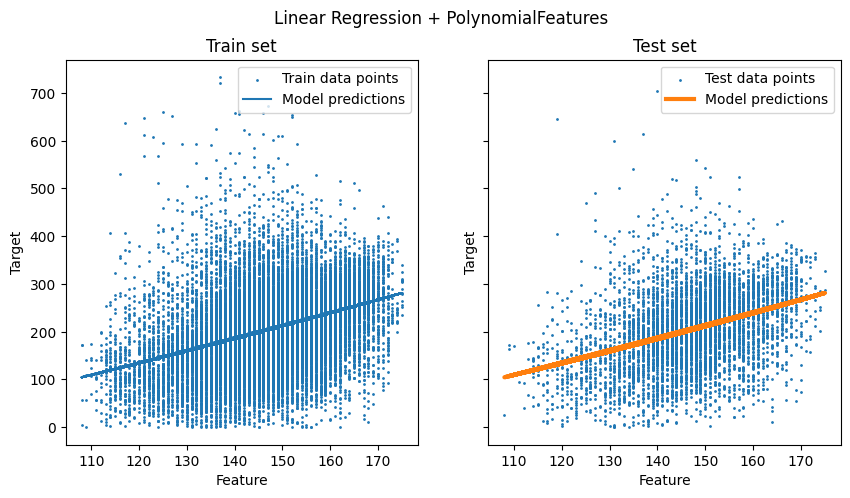

Mean squared error: 1885.84
Coefficient of determination: 0.15


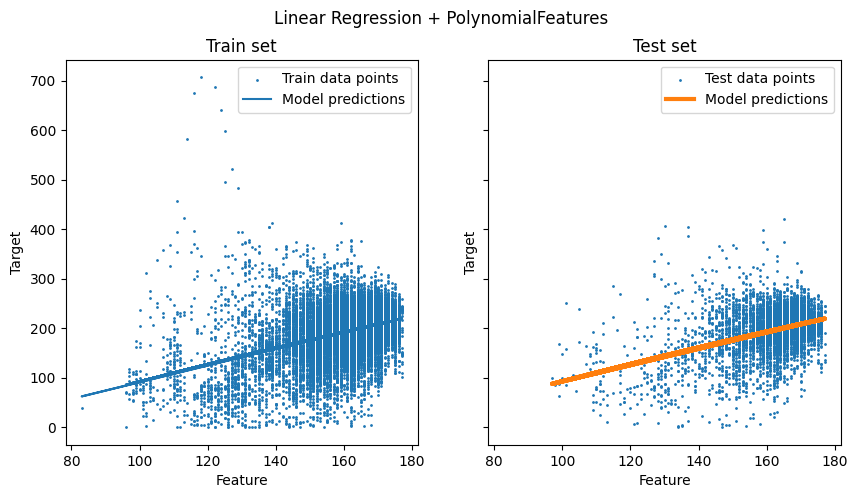

Mean squared error: 2007.80
Coefficient of determination: 0.19


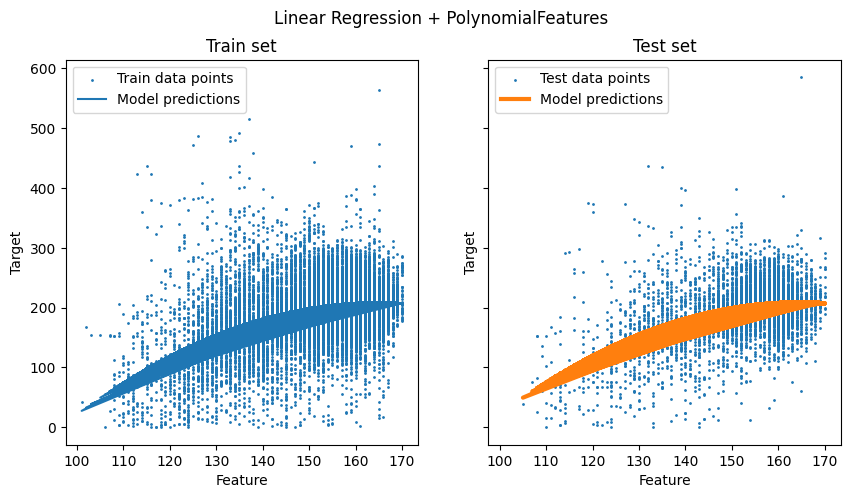

Mean squared error: 1764.97
Coefficient of determination: 0.23


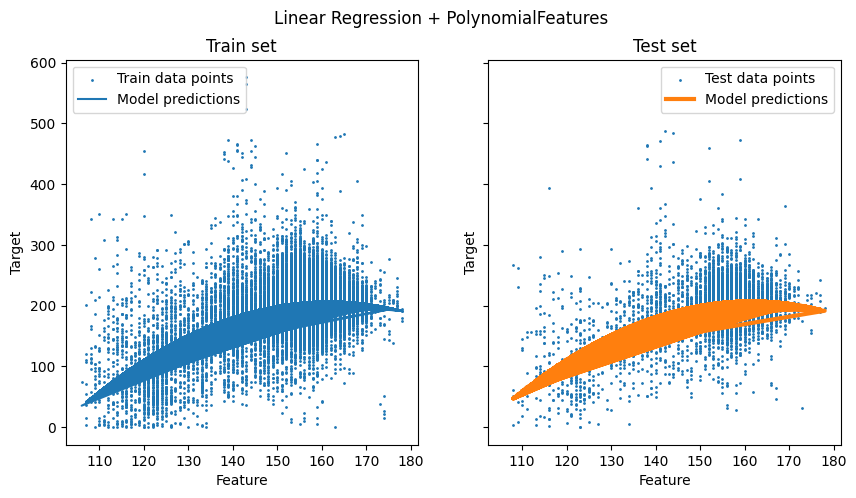

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

for i in range(len(stravas)):
    strava = stravas[i]
    stravaT = strava[[
          'hr'
        #'cad'
        #  ,'temperature'
        #  ,'power'
        #  ,'gradient'
        #  ,'velocity'
    ]]
    #X = pd.DataFrame(scale(stravaT), index=stravaT.index, columns=stravaT.columns)
    X = pd.DataFrame(stravaT, index=stravaT.index, columns=stravaT.columns)
    y = strava.power
    X_Train, X_Test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 4200)

    lm = LinearRegression()
    lm.fit(X_Train,y_train)

    pf = PolynomialFeatures(degree=2)
    poly_X_Train = pf.fit_transform(X_Train)
    regressor = LinearRegression().fit(poly_X_Train, y_train)

    poly_X_Test = pf.fit_transform(X_Test)
    y_pred = regressor.predict(poly_X_Test)

    print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

    ax[0].scatter(X_Train.iloc[:, 0], y_train, label="Train data points",  s = 1)
    ax[0].plot(
        X_Train.iloc[:, 0],
        regressor.predict(poly_X_Train),
        label="Model predictions"
    )

    ax[0].set(xlabel="Feature", ylabel="Target", title="Train set")
    ax[0].legend()

    ax[1].scatter(X_Test.iloc[:, 0], y_test,s =1, label="Test data points")
    ax[1].plot(X_Test.iloc[:, 0], y_pred, linewidth=3, color="tab:orange", label="Model predictions")
    ax[1].set(xlabel="Feature", ylabel="Target", title="Test set")
    ax[1].legend()

    fig.suptitle("Linear Regression + PolynomialFeatures")

    plt.show()

Added in HR and Power Zones to categorise data.

In [41]:
ftp = 240
maxhr = 180

def hrzone(row):
    hr = row['hr']
    if hr > (0.9*maxhr):
        return 5
    if hr > (0.8*maxhr):
        return 4
    if hr > (0.7*maxhr):
        return 3
    if hr > (0.6*maxhr):
        return 2
    if hr > (0.5*maxhr):
        return 1
    return 0

def pwrzone(row):
    power = row['power']
    if power > (1.2*ftp):
        return 7
    if power > (1.06*ftp):
        return 6
    if power > (0.95*ftp):
        return 5
    if power > (0.88*ftp):
        return 4
    if power > (0.76*ftp):
        return 3
    if power > (0.55*ftp):
        return 2
    return 1

for i in range(len(stravas)):
    strava = stravas[i]
    strava['hr_zone'] = strava.apply(hrzone, axis=1)
    strava['power_zone'] = strava.apply(pwrzone, axis=1)

In [42]:
stravas[1]

,power,hr,cad,temperature,distance,gradient,velocity,hr_zone,power_zone
time,,,,,,,,,
2022-07-10 05:04:57,92.0,101,31,11.0,4.126582,0.000000,14.855696,1,1
2022-07-10 05:04:58,157.0,101,41,11.0,4.596287,0.000000,16.546632,1,2
2022-07-10 05:04:59,170.0,100,44,11.0,4.398578,0.000000,15.834881,1,2
2022-07-10 05:05:00,162.0,100,44,11.0,4.767194,0.000000,17.161899,1,2
2022-07-10 05:05:01,147.0,100,43,11.0,5.334696,0.000000,19.204904,1,2
...,...,...,...,...,...,...,...,...,...
2022-07-10 17:23:14,166.0,164,49,24.0,1.683654,11.878927,6.103768,5,2
2022-07-10 17:23:15,166.0,163,51,24.0,1.915341,0.000000,6.895229,5,2
2022-07-10 17:23:16,169.0,164,51,24.0,1.683654,11.878927,6.103768,5,2


Strava/Ronde_Van_Vlaanderen_2022.gpx


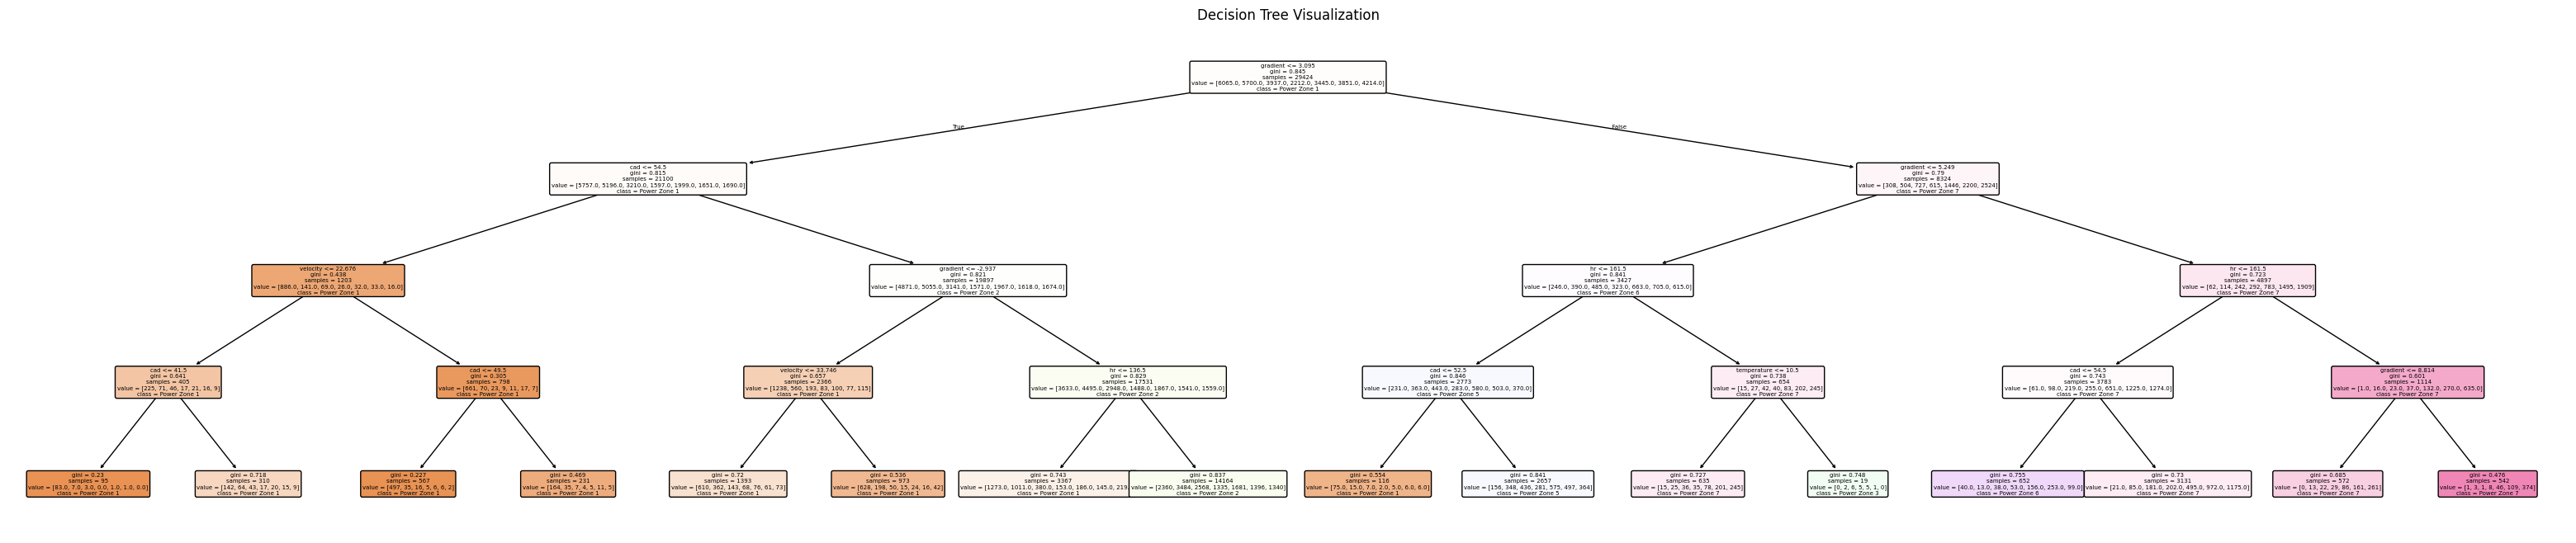

Strava/L_Etape_2022.gpx


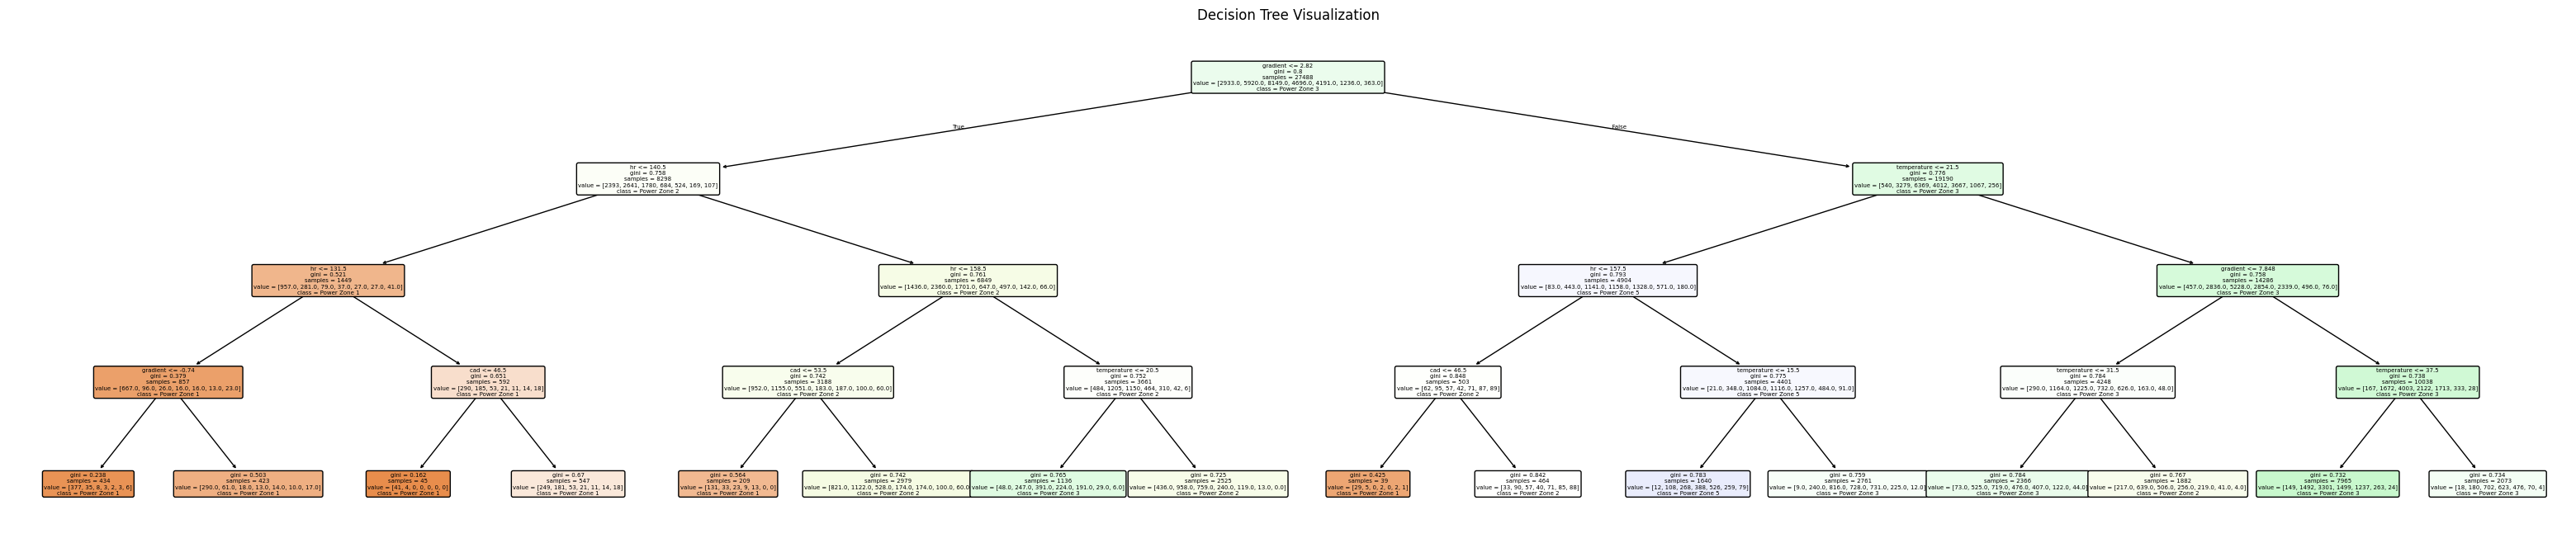

Strava/L_Etape_2023.gpx


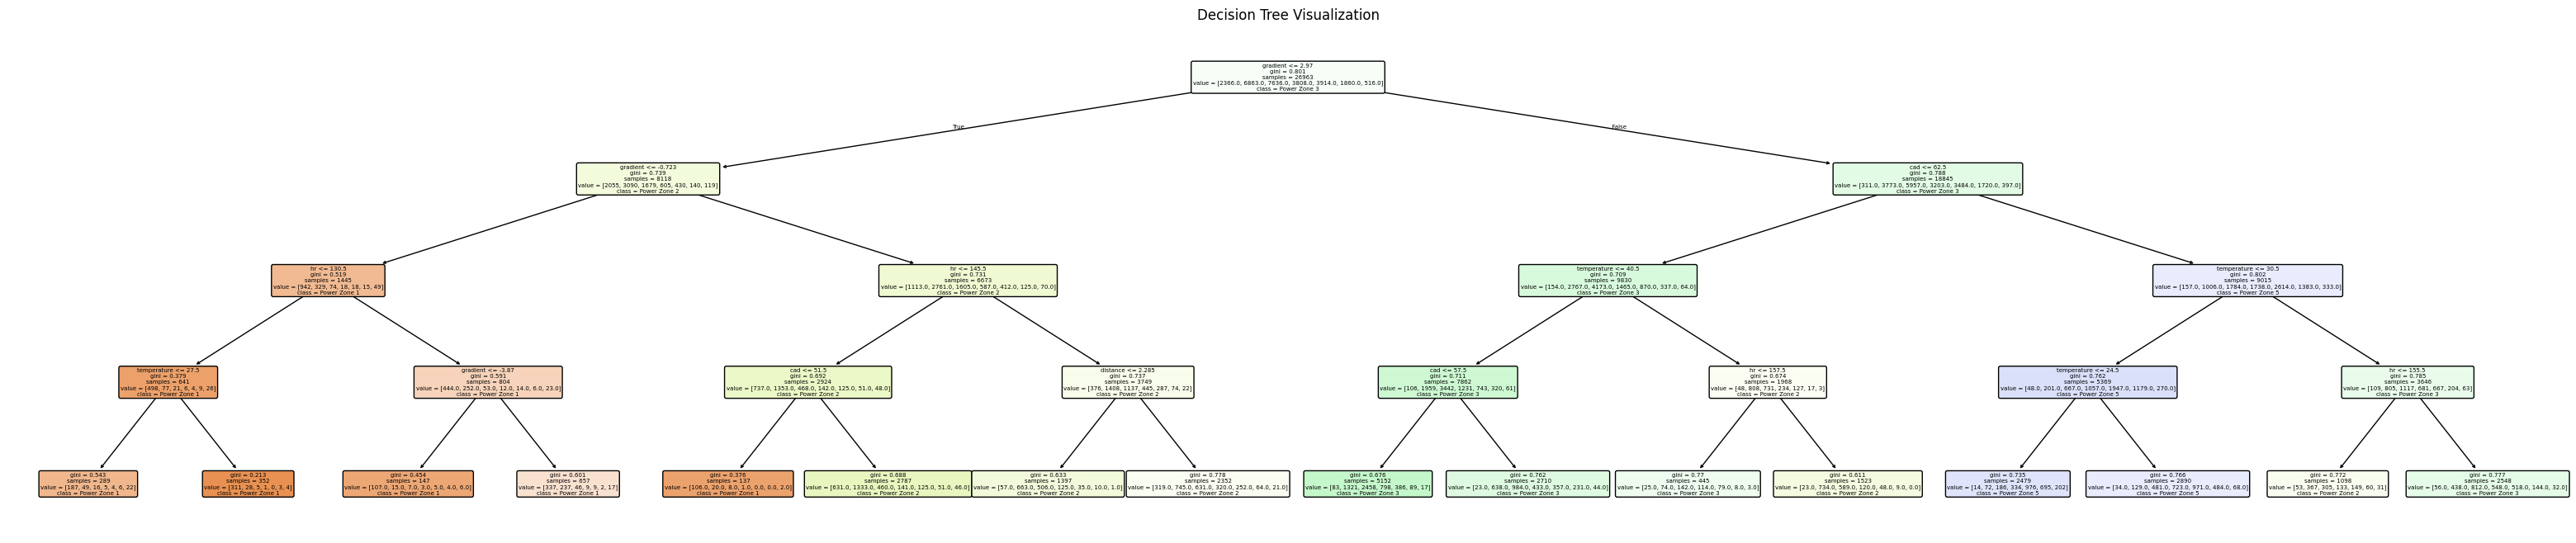

Strava/L_Etape_2024.gpx


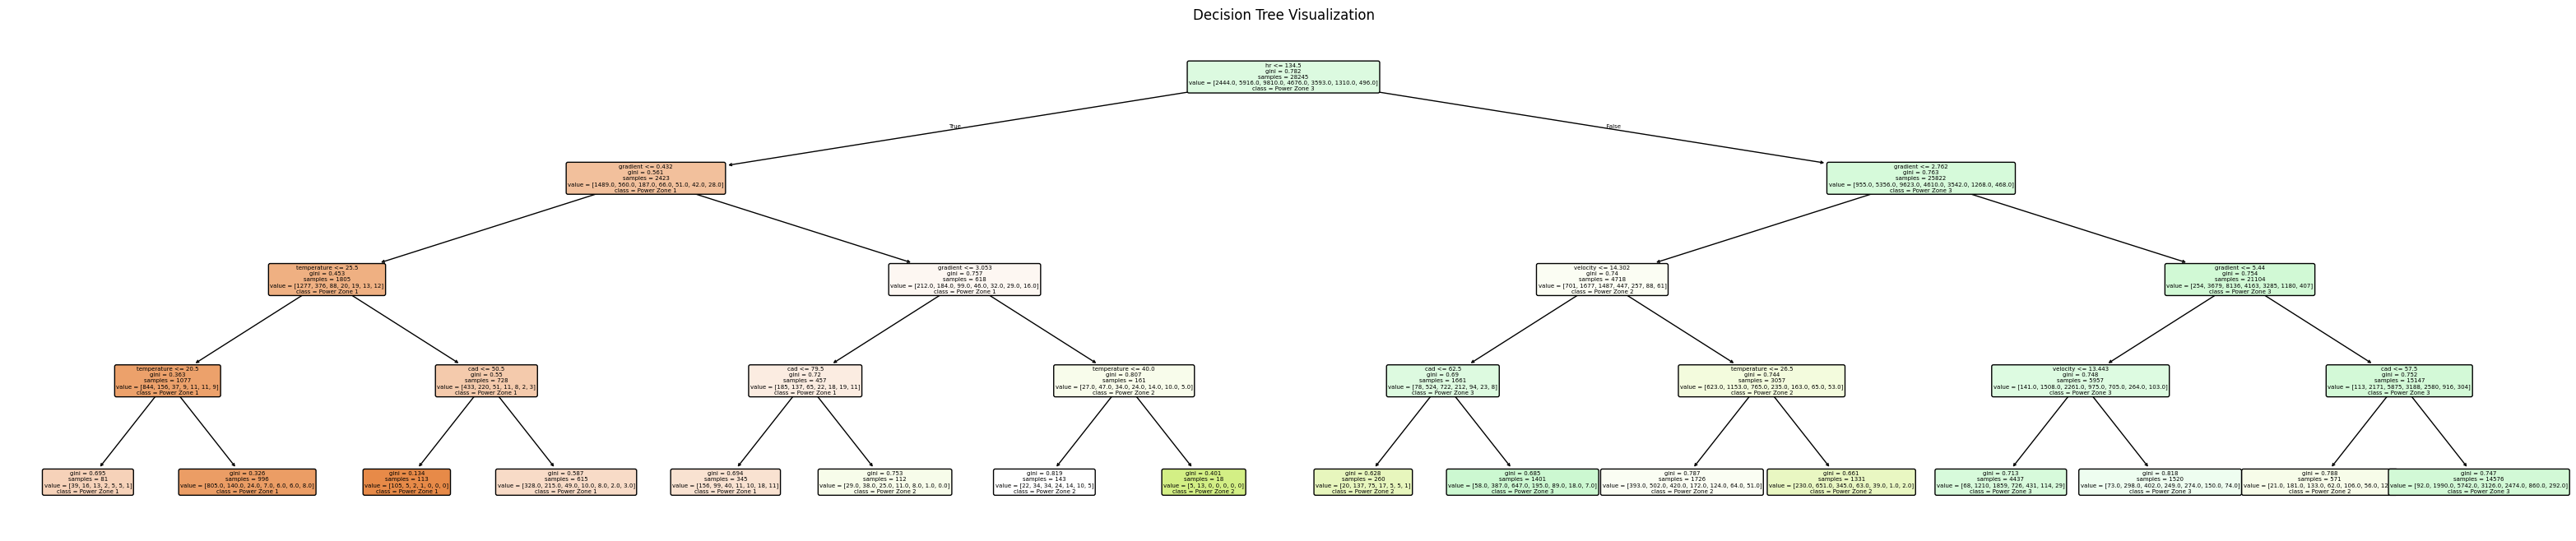

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import dtreeviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

for i in range(len(stravas)):
    print(paths[i])
    strava = stravas[i]
    X = strava.copy()
    X = X.drop(['power_zone'], axis=1)
    X = X.drop(['power'], axis=1)
    Y = strava.power_zone

    le = LabelEncoder()
    Y_encoded = le.fit_transform(Y)

    # First, handle the missing values
    # Option 1: Fill NaN with median values
    X = X.fillna(X.median())

    model = DecisionTreeClassifier(max_depth=4)
    model.fit(X,Y_encoded)


    # Assuming you have your decision tree model 'dt', and data X, Y
    plt.figure(figsize=(40,8))
    plot_tree(model, feature_names=X.columns,
              class_names=[ 'Power Zone 1', 'Power Zone 2', 'Power Zone 3', 'Power Zone 4','Power Zone 5','Power Zone 6', 'Power Zone 7'],
              filled=True, rounded=True, fontsize=5)
    plt.title("Decision Tree Visualization")
    plt.show()



# This works, prefer this.
    #viz_model = dtreeviz.model(model,
    #                           X_train=X, y_train=Y_encoded,
    #                           feature_names=X.columns,
    #                           target_name='Power',
    #                           class_names=[ 'Power Zone 1', 'Power Zone 2', 'Power Zone 3', 'Power Zone 4','Power Zone 5','Power Zone 6', 'Power Zone 7'],)
    #viz_model.view()